In [1]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3, venn3_circles
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
from sklearn.linear_model import LinearRegression
import glob
import os
import h5_utilities_module as h5u

In [2]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.
    Args:
        indata (ndarray): 1d or 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (float): how many times the noise level must a state be? (e.g. 2 = twice the noise level)
    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): array the same size as indata. Contains 1 where states occurred, 0 elsewhere.
    """
    # Handle 1D vs 2D input
    if indata.ndim == 1:
        # Reshape 1D to 2D for uniform processing
        indata_2d = indata.reshape(1, -1)
        is_1d_input = True
    else:
        indata_2d = indata
        is_1d_input = False
    
    state_details = np.array([])
    state_array = np.zeros_like(indata_2d)
   
    state_magnitude_thresh = (1 / n_classes) * mag_thresh
    
    for t in range(indata_2d.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata_2d[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]
        
        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))
    
    # Reshape and filter state_details
    if len(state_details) > 0:
        state_details = state_details.reshape(-1, 3)
        state_details = state_details[state_details[:, 2] > temporal_thresh, :]
        
        # Update state_array using state_details information
        for j in range(len(state_details)):
            state_trial, state_start, state_len = state_details[j].astype(int)
            state_array[state_trial, state_start:(state_start + state_len)] = 1
    else:
        state_details = np.array([]).reshape(0, 3)  # Empty array with correct shape
    
    # Return in original dimensionality
    if is_1d_input:
        state_array = state_array.reshape(-1)  # Flatten back to 1D
    
    return state_details, state_array


def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])

In [3]:
# where are the data?
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/single_neuron_summary/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)

In [4]:
h5u.list_hdf5_data(data_files[0])

Datasets in 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/single_neuron_summary\D20231219_Rec05_summary.h5':
brain_area
shuffle_auc_scores
state_auc_scores
t_factor_betas
t_factor_pvals
ts
valstate_betas
valstate_pvals


In [5]:
# initialize lists to accumulate data into
brain_area = []
state_auc_scores = []
shuffle_auc_scores = []
valstate_betas = []
valstate_pvals = []
t_factor_pvals = []
t_factor_betas = []
subject = []

# accumulate data from each file

for this_file in data_files:
    
    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1
            
    # Append the data to the lists
    brain_area.append(h5u.pull_from_h5(this_file, 'brain_area'))
    subject.append(np.ones(len(h5u.pull_from_h5(this_file, 'brain_area')), )*s)
    state_auc_scores.append(h5u.pull_from_h5(this_file, 'state_auc_scores'))
    shuffle_auc_scores.append(h5u.pull_from_h5(this_file, 'shuffle_auc_scores'))
    t_factor_pvals.append(h5u.pull_from_h5(this_file, 't_factor_pvals'))
    t_factor_betas.append(h5u.pull_from_h5(this_file, 't_factor_betas'))
    valstate_betas.append(h5u.pull_from_h5(this_file, 'valstate_betas'))
    valstate_pvals.append(h5u.pull_from_h5(this_file, 'valstate_pvals'))

ts = h5u.pull_from_h5(this_file, 'ts')

# convert everything back to arrays
brain_area = np.concatenate(brain_area, axis=0)
subject = np.concatenate(subject, axis=0)
state_auc_scores = np.concatenate(state_auc_scores, axis=0)
shuffle_auc_scores = np.concatenate(shuffle_auc_scores, axis=0)
t_factor_pvals = np.concatenate(t_factor_pvals, axis=0)
valstate_betas = np.concatenate(valstate_betas, axis=0)
valstate_pvals = np.concatenate(valstate_pvals, axis=0)

In [6]:
# pull out the factors
thresh = .01 # this is severe enough to account for any multiple-comparisons issues
state_coding = (t_factor_pvals[:,:,0] < thresh) | (t_factor_pvals[:,:,1] < thresh) | (t_factor_pvals[:,:,2] < thresh)
val_coding = (t_factor_pvals[:,:,3] < thresh) 
state_val_coding = (t_factor_pvals[:,:,4] < thresh) | (t_factor_pvals[:,:,5] < thresh) | (t_factor_pvals[:,:,6] < thresh)

temporal_thresh = 6 # a neuron must be continuously selective for 1.5x the window length (6 samples = 150 ms; window len = 100 ms)
_, state_coding2 = find_candidate_states(state_coding, 1, temporal_thresh, .5)
_, val_coding2 = find_candidate_states(val_coding, 1, temporal_thresh, .5)
_, state_val_coding2 = find_candidate_states(state_val_coding, 1, temporal_thresh, .5)

(0.0, 40.0)

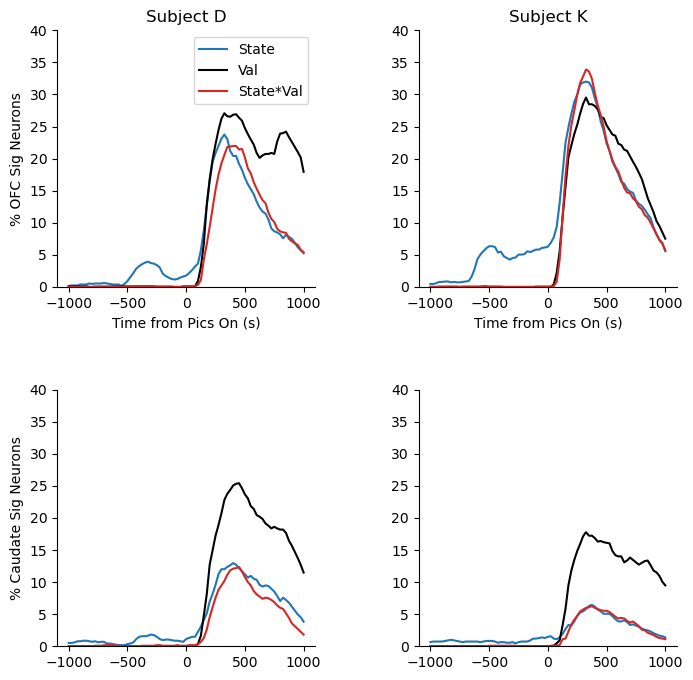

In [7]:
ofc_ix = brain_area == 1
cdn_ix = brain_area == 0
d_ix = subject == 0
k_ix = subject == 1

state_col = 'tab:blue'
val_col = 'black'
state_val_col = 'tab:red'



ylims = (0, 40)

fig, prop_ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

prop_ax[0,0].plot(ts, np.mean(state_coding2[ofc_ix & d_ix, :], axis=0) * 100, label='State', color=state_col)
prop_ax[0,0].plot(ts, np.mean(val_coding2[ofc_ix & d_ix, :], axis=0) * 100, label='Val', color=val_col)
prop_ax[0,0].plot(ts, np.mean(state_val_coding2[ofc_ix & d_ix, :], axis=0) * 100, label='State*Val', color = state_val_col)
prop_ax[0,0].spines['top'].set_visible(False)
prop_ax[0,0].spines['right'].set_visible(False)
prop_ax[0,0].set_xlabel('Time from Pics On (s)')
prop_ax[0,0].set_ylabel('% OFC Sig Neurons')
prop_ax[0,0].set_title('Subject D')
prop_ax[0,0].set_ylim(ylims)
prop_ax[0,0].legend()


prop_ax[1,0].plot(ts, np.mean(state_coding2[cdn_ix & d_ix, :], axis=0) * 100, color=state_col)
prop_ax[1,0].plot(ts, np.mean(val_coding2[cdn_ix & d_ix, :], axis=0) * 100, color=val_col)
prop_ax[1,0].plot(ts, np.mean(state_val_coding2[cdn_ix & d_ix, :], axis=0) * 100, color = state_val_col)
prop_ax[1,0].spines['top'].set_visible(False)
prop_ax[1,0].spines['right'].set_visible(False)
prop_ax[1,0].set_ylim(ylims)
prop_ax[1,0].set_ylabel('% Caudate Sig Neurons')

prop_ax[0,1].plot(ts, np.mean(state_coding2[ofc_ix & k_ix, :], axis=0) * 100, label='State', color=state_col)
prop_ax[0,1].plot(ts, np.mean(val_coding2[ofc_ix & k_ix, :], axis=0) * 100, label='Val', color=val_col)
prop_ax[0,1].plot(ts, np.mean(state_val_coding2[ofc_ix & k_ix, :], axis=0) * 100, label='State*Val', color = state_val_col)
prop_ax[0,1].spines['top'].set_visible(False)
prop_ax[0,1].spines['right'].set_visible(False)
prop_ax[0,1].set_ylim(ylims)
prop_ax[0,1].set_xlabel('Time from Pics On (s)')
prop_ax[0,1].set_title('Subject K')


prop_ax[1,1].plot(ts, np.mean(state_coding2[cdn_ix & k_ix, :], axis=0) * 100, color=state_col)
prop_ax[1,1].plot(ts, np.mean(val_coding2[cdn_ix & k_ix, :], axis=0) * 100, color=val_col)
prop_ax[1,1].plot(ts, np.mean(state_val_coding2[cdn_ix & k_ix, :], axis=0) * 100, color = state_val_col)
prop_ax[1,1].spines['top'].set_visible(False)
prop_ax[1,1].spines['right'].set_visible(False)
prop_ax[1,1].set_ylim(ylims)

# save the figure
#fig.savefig('one_hot_sig_units.svg')


In [41]:
state_at_choice = np.any(state_coding2[:, 41:56], axis=1)
val_at_choice = np.any(val_coding2[:, 41:56], axis=1)
stateval_at_choice = np.any(state_val_coding2[:, 41:56], axis=1)

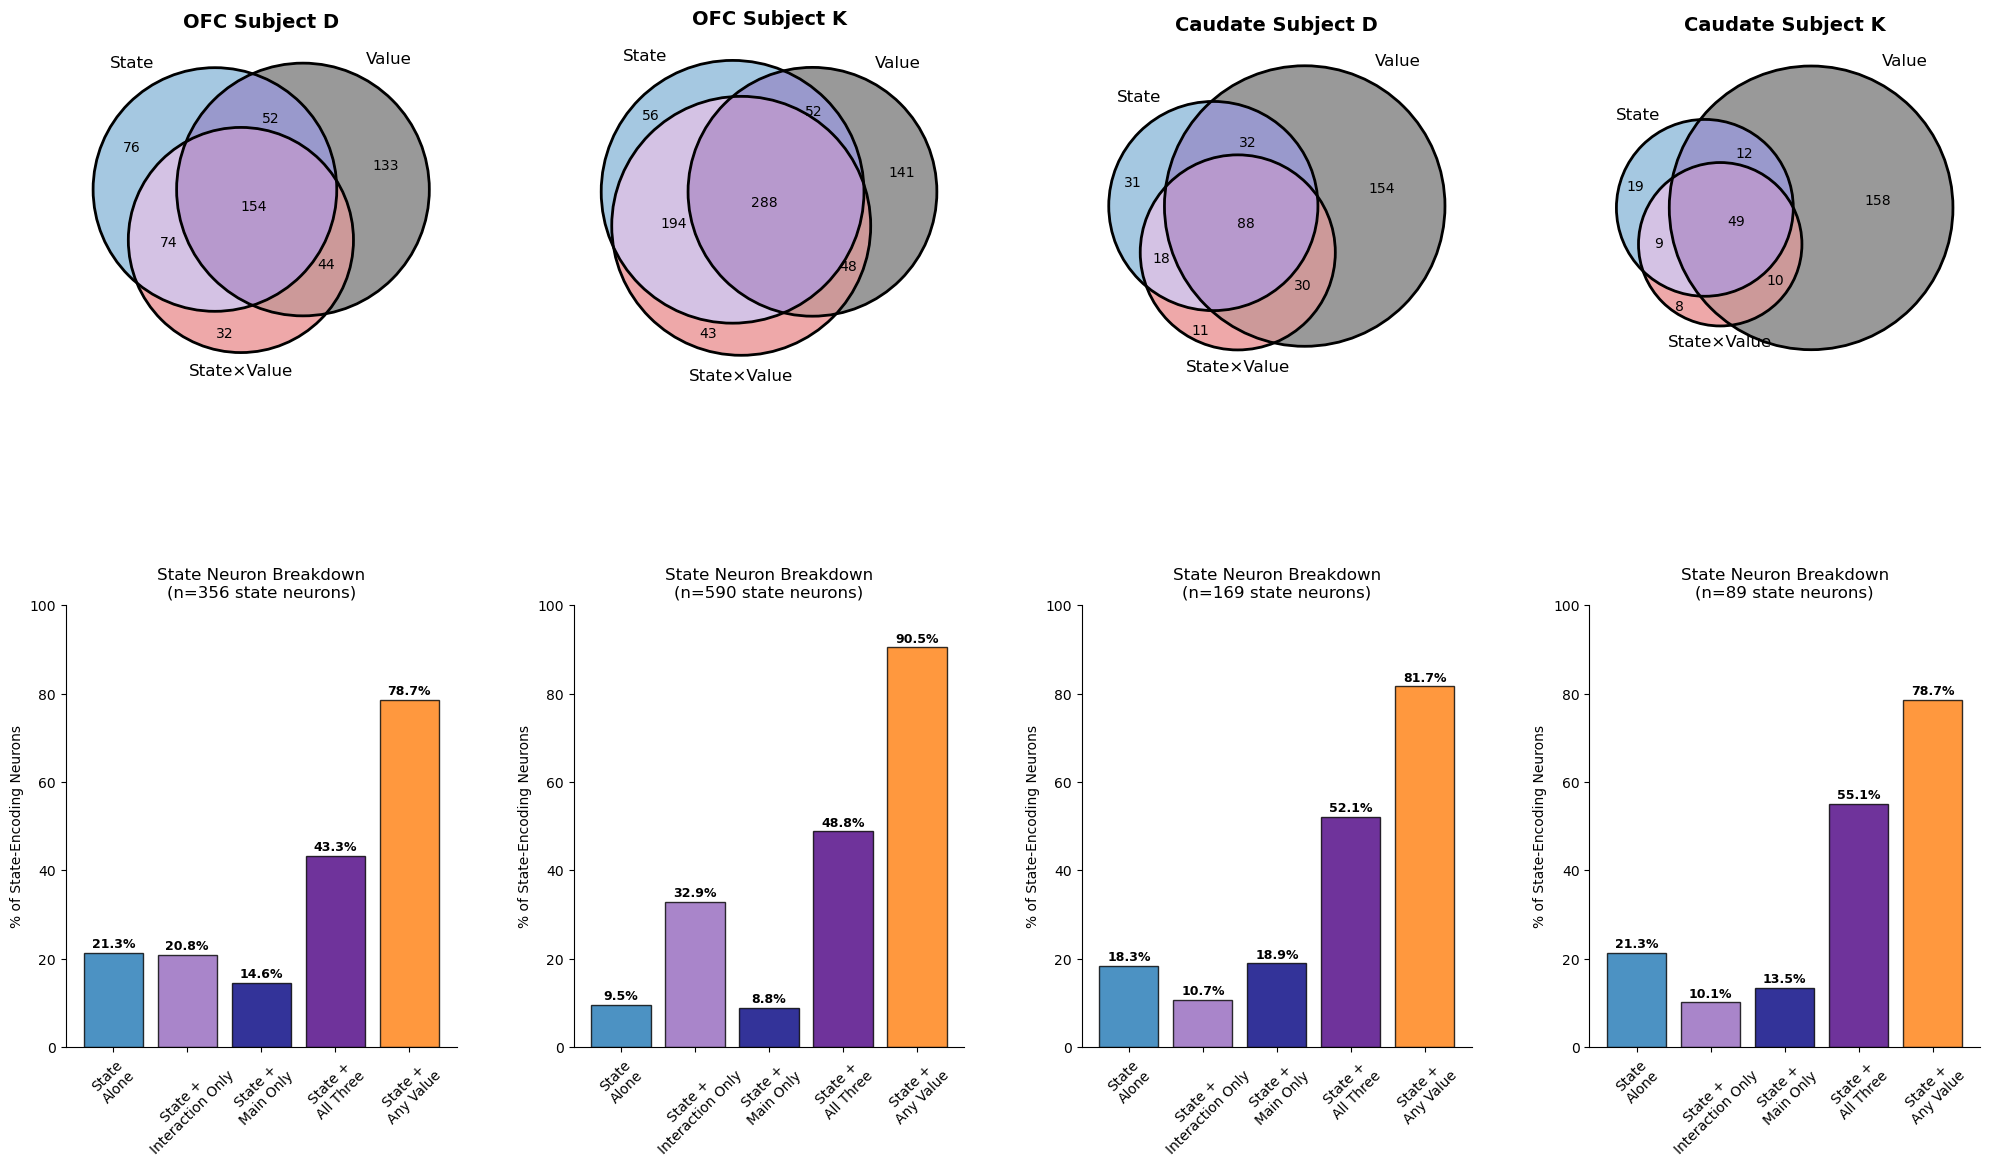

In [ ]:

# Define meta-groupings 
pure_state = state_at_choice & ~val_at_choice & ~stateval_at_choice
pure_val = val_at_choice & ~state_at_choice & ~stateval_at_choice
pure_stateval = stateval_at_choice & ~state_at_choice & ~val_at_choice

# State breakdown categories (your 5 specific categories)
state_alone = state_at_choice & ~val_at_choice & ~stateval_at_choice
state_with_any_value = state_at_choice & (val_at_choice | stateval_at_choice)
state_with_interaction_only = state_at_choice & ~val_at_choice & stateval_at_choice
state_with_main_effect_only = state_at_choice & val_at_choice & ~stateval_at_choice
state_with_all3 = state_at_choice & val_at_choice & stateval_at_choice

# Define combinations and colors
combinations = [
    (ofc_ix & d_ix, 'OFC Subject D'),
    (ofc_ix & k_ix, 'OFC Subject K'), 
    (cdn_ix & d_ix, 'Caudate Subject D'),
    (cdn_ix & k_ix, 'Caudate Subject K')
]

# Venn diagram colors
venn_colors = {
    'state_only': 'tab:blue',
    'val_only': 'black',
    'stateval_only': 'tab:red',
    'state_val': 'navy',           # blue + black
    'state_stateval': 'tab:purple', # blue + red  
    'val_stateval': 'maroon',       # black + red
    'all_three': 'indigo'           # blue + black + red
}

# Create the combined figure
fig, axes = plt.subplots(2, 4, figsize=(20, 12))

# Create plots for each combination
for i, (mask, title) in enumerate(combinations):
    
    # ========================================================================
    # TOP ROW: VENN DIAGRAMS
    # ========================================================================
    ax_venn = axes[0, i]
    
    # Get neurons for this combination
    state_neurons = set(np.where(state_at_choice[mask])[0])
    val_neurons = set(np.where(val_at_choice[mask])[0])
    stateval_neurons = set(np.where(stateval_at_choice[mask])[0])
    
    total_neurons = np.sum(mask)
    
    if len(state_neurons) == 0 and len(val_neurons) == 0 and len(stateval_neurons) == 0:
        ax_venn.text(0.5, 0.5, f'No significant neurons\n({total_neurons} total)', 
                     ha='center', va='center', transform=ax_venn.transAxes, fontsize=12)
        ax_venn.set_title(title, fontsize=14, fontweight='bold')
    else:
        # Create the 3-way Venn diagram
        venn = venn3([state_neurons, val_neurons, stateval_neurons], 
                     ('State', 'Value', 'State×Value'), ax=ax_venn)
        
        # Apply colors
        if venn.get_patch_by_id('100'): venn.get_patch_by_id('100').set_color(venn_colors['state_only'])
        if venn.get_patch_by_id('010'): venn.get_patch_by_id('010').set_color(venn_colors['val_only']) 
        if venn.get_patch_by_id('001'): venn.get_patch_by_id('001').set_color(venn_colors['stateval_only'])
        if venn.get_patch_by_id('110'): venn.get_patch_by_id('110').set_color(venn_colors['state_val'])
        if venn.get_patch_by_id('101'): venn.get_patch_by_id('101').set_color(venn_colors['state_stateval'])
        if venn.get_patch_by_id('011'): venn.get_patch_by_id('011').set_color(venn_colors['val_stateval'])
        if venn.get_patch_by_id('111'): venn.get_patch_by_id('111').set_color(venn_colors['all_three'])
        
        # Add circles for better visibility
        venn3_circles([state_neurons, val_neurons, stateval_neurons], 
                      linestyle='solid', linewidth=2, ax=ax_venn)
        
        ax_venn.set_title(title, fontsize=14, fontweight='bold')
    
    # ========================================================================
    # BOTTOM ROW: 5-BAR BREAKDOWN PLOTS
    # ========================================================================
    ax_bar = axes[1, i]
    
    # Calculate counts for this region/subject
    n_state_alone = np.sum(state_alone[mask])
    n_state_any_value = np.sum(state_with_any_value[mask])
    n_state_interaction_only = np.sum(state_with_interaction_only[mask])
    n_state_main_only = np.sum(state_with_main_effect_only[mask])
    n_state_all3 = np.sum(state_with_all3[mask])  # All 3 factors
    n_total_state = np.sum(state_at_choice[mask])  # Total state neurons
    
    if n_total_state > 0:
        # All percentages as % of state neurons
        state_alone_pct = n_state_alone / n_total_state * 100
        state_any_value_pct = n_state_any_value / n_total_state * 100
        state_interaction_only_pct = n_state_interaction_only / n_total_state * 100
        state_main_only_pct = n_state_main_only / n_total_state * 100
        state_all3_pct = n_state_all3 / n_total_state * 100
        
        # All 5 categories and percentages
        categories = ['State\nAlone', 'State +\nInteraction Only', 'State +\nMain Only', 'State +\nAll Three', 'State +\nAny Value']
        percentages = [state_alone_pct, state_interaction_only_pct, state_main_only_pct, state_all3_pct, state_any_value_pct]
        
        # Map bar categories to their corresponding Venn diagram colors
        bar_colors = [
            'tab:blue',      # State Alone = pure state wedge (tab:blue)
            'tab:purple',                   # State + val + interaction
            'navy',  # State + Interaction Only (tab:purple)
            'indigo',       # State + Main Only = state+value wedge (navy)
            'tab:orange'                     # state + either main effect or interaction
        ]
        
        bars = ax_bar.bar(categories, percentages, color=bar_colors, alpha=0.8, edgecolor='black')
        
        # Add percentage labels on bars
        for bar, pct in zip(bars, percentages):
            if pct > 0:
                height = bar.get_height()
                ax_bar.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax_bar.set_ylabel('% of State-Encoding Neurons')
        ax_bar.set_title(f'State Neuron Breakdown\n(n={n_total_state} state neurons)')
        ax_bar.set_ylim(0, 100)
        
    else:
        ax_bar.text(0.5, 0.5, 'No state neurons', ha='center', va='center', 
                   transform=ax_bar.transAxes, fontsize=12)
        ax_bar.set_title('State Neuron Breakdown\n(n=0 state neurons)')
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()
